<a href="https://colab.research.google.com/github/eksq1/dodo/blob/main/inclass/UNet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


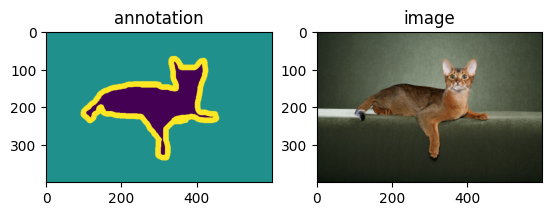

In [ ]:
import glob
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

path_to_annotation = "/content/drive/MyDrive/annotations/trimaps"
path_to_image = "/content/drive/MyDrive/images"

images = sorted(glob.glob(path_to_image + "/*.jpg"))

# 데이터의 오류를 수정하기 위한 코드
# 이미지 리스트를 돌아다니면서 RGB 이미지가 아닌 경우, 그 이미지와 어노테이션 파일을 삭제함
for i in images:
    img = Image.open(i)
    img = np.array(img)
    if img.shape[-1] != 3:
        filename = i.split("/")[-1].split(".")[0]
        gt_filename = filename + ".png"

        os.remove(os.path.join(path_to_annotation, gt_filename))
        os.remove(i)

# 특정 이미지를 열어 시각화함
annotation = Image.open(path_to_annotation + "/Abyssinian_1.png")
plt.subplot(1, 2, 1)
plt.title("annotation")
plt.imshow(annotation)

image = Image.open(path_to_image + "/Abyssinian_1.jpg")
plt.subplot(1, 2, 2)
plt.title("image")
plt.imshow(image)

plt.show()

In [ ]:
import torch
from torch.utils.data.dataset import Dataset

class Pets(Dataset):
  def __init__(self, path_to_image,
               path_to_anno,
               train=True,
               transforms=None,
               input_size=(128, 128)):

      """
      사용자 정의 데이터셋 클래스
      path_to_img: 이미지 경로
      path_to_anno: 어노테이션(마스크) 경로
      train: 학습용 여부 설정
      transforms: 이미지에 적용할 전처리(transform) 함수
      input_size: 입력 이미지 및 마스크의 크기(디폴트: 128x128)
      """

      # 이미지 및 어노테이션(마스크) 파일 경로를 정렬된 리스트로 불러옴
      self.images = sorted(glob.glob(path_to_image+"/*.jpg"))
      self.annotations = sorted(glob.glob(path_to_anno + "/*.png"))

      min_len = min(len(self.images), len(self.annotations))
      pairs = list(zip(self.images[:min_len], self.annotations[:min_len]))

      split = int(0.8 * len(pairs))
      train_pairs = pairs[:split]
      test_pairs = pairs[split:]

      self.X_train, self.Y_train = zip(*train_pairs)
      self.X_test, self.Y_test = zip(*test_pairs)

      self.X_train = list(self.X_train)
      self.Y_train = list(self.Y_train)
      self.X_test = list(self.X_test)
      self.Y_test = list(self.Y_test)

      self.train = train
      self.transforms = transforms
      self.input_size = input_size

      # 학습 여부, transform, input size 저장
      self.train = train
      self.transforms = transforms
      self.input_size = input_size

  def __len__(self):
      if self.train:
          return len(self.X_train)
      else:
          return len(self.X_test)


      # 마스크 이미지 전처리 함수
      """
      마스크 이미지 전처리 함수
      - 사이즈를 input_size로 조정
      - 픽셀 값을 float32로 변환
      - 클래스 1: 배경 또는 경계(= 1.0), 클래스 0: 객체(= 0.0)로 바꿈
      - Pytorch tensor로 변환
      """

  def preprocess_mask(self, mask):
      mask = mask.resize(self.input_size)
      mask = np.array(mask).astype(np.float32)
      mask[mask != 2.0] = 1.0
      mask[mask == 2.0] = 0.0
      mask = torch.tensor(mask)
      return mask

  def __getitem__(self, i):
      if self.train:
         X_train = Image.open(self.X_train[i])
         X_train = self.transforms(X_train)
         Y_train = Image.open(self.Y_train[i])
         Y_train = self.preprocess_mask(Y_train)

         return X_train, Y_train

      else:
          X_test = Image.open(self.X_test[i])
          X_test = self.transforms(X_test)
          Y_test = Image.open(self.Y_test[i])
          Y_test = self.preprocess_mask(Y_test)

          return X_test, Y_test

In [ ]:
import torch.nn as nn

class UNet(nn.Module):
   def __init__(self):
       super(UNet, self).__init__()

       # 인코더
       # 특징 추출하는 conv2d 2개 + MaxPooling으로 다운샘플링(해상도 감소, 채널 증가)

       # 인코더 레벨 1
       self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
       self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

       # 인코더 레벨 2
       self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
       self.enc2_2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

       # 인코더 레벨 3
       self.enc3_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
       self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
       self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

       # 인코더 레벨 4
       self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
       self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
       self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

       # 가장 깊은 곳의 특징을 표현하는 부분
       self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
       self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

       # 디코더 (Expanding Path)
       # 업샘플링 -> skip connection과 연결(concatenation) -> Conv2d

       # 디코더 레벨 4
       self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
       self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
       self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

       # 디코더 레벨 3
       self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
       self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
       self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

       # 디코더 레벨 2
       self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
       self.dec2_1 = nn.Conv2d(384, 128, kernel_size=3, padding=1)
       self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

       # 디코더 레벨 1
       self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
       self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
       self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
       self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)  # 출력 크기를 binary mask로 맞춰줌

       # 사용할 활성화 함수 정의함
       self.relu = nn.ReLU()
       self.sigmoid = nn.Sigmoid()

   def forward(self, x):
       # 인코더: 특징 추출, 다운샘플링
       x = self.enc1_1(x)
       x = self.relu(x)
       e1 = self.enc1_2(x)         # 디코더에서 사용하기 위해 따로 변수를 지정
       e1 = self.relu(e1)          # 활성곱층의 출력의 활성화
       x = self.pool1(e1)

       x = self.enc2_1(x)
       x = self.relu(x)
       e2 = self.enc2_2(x)
       e2 = self.relu(e2)
       x = self.pool2(e2)

       x = self.enc3_1(x)
       x = self.relu(x)
       e3 = self.enc3_2(x)
       e3 = self.relu(e3)
       x = self.pool3(e3)

       x = self.enc4_1(x)
       x = self.relu(x)
       e4 = self.enc4_2(x)
       e4 = self.relu(e4)
       x = self.pool4(e4)

       x = self.enc5_1(x)
       x = self.relu(x)
       x = self.enc5_2(x)
       x = self.relu(x)
       x = self.upsample4(x)

       # 디코더: 업샘플링 + skip connection + 복원
       x = torch.cat([x, e4], dim=1)
       x = self.dec4_1(x)
       x = self.relu(x)
       x = self.dec4_2(x)
       x = self.relu(x)

       x = self.upsample3(x)
       x = torch.cat([x, e3], dim=1)
       x = self.dec3_1(x)
       x = self.relu(x)
       x = self.dec3_2(x)
       x = self.relu(x)

       x = self.upsample2(x)
       x = torch.cat([x, e2], dim=1)
       x = self.dec2_1(x)
       x = self.relu(x)
       x = self.dec2_2(x)
       x = self.relu(x)

       x = self.upsample1(x)
       x = torch.cat([x, e1], dim=1)
       x = self.dec1_1(x)
       x = self.relu(x)
       x = self.dec1_2(x)
       x = self.relu(x)
       x = self.dec1_3(x)  # 최종 출력

       x = torch.squeeze(x)  # 흑백 이미지를 그리기 위해 채널을 없앰
       # 채널 차원을 제거하였음. (batch, 1, h, w) -> (batch, h, w)

       return x

## 데이터 전처리 정의

In [ ]:
import tqdm

# 데이터 전처리 도구
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize

# 옵티마이저 설정, 데이터 로더 불러오기
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

# GPU 사용 가능 여부에 따라 device 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 입력 이미지에 적용할 전처리 파이프라인을 적용함
# -> 이미지 크기를 (128, 128)로 조정하는 것
transform = Compose([
    Resize((128, 128)),
    ToTensor()
])

## 데이터 불러오기

In [ ]:
# 학습 데이터 생성
# transform 적용
train_set = Pets(path_to_image=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transform)  # train=True는 기본값이라 생각하였음

# 평가용 데이터 생성
# transform 적용
test_set = Pets(path_to_image=path_to_image,
                path_to_anno=path_to_annotation,
                transforms=transform,
                train=False)  # 평가용

# 학습용 DataLoader
# 32개씩 batch 단위로 데이터를 불러오고, 매 epoch마다 데이터 순서를 섞음(shuffle=True)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# 평가용 DataLoader (shuffle할 필요가 없음, Shuffle 안하는 것이 기본값이라 생각함)
test_loader = DataLoader(test_set)

## 학습에 필요한 요소 정의

In [ ]:
# 모델 정의
model = UNet().to(device)

# 학습률 정의
learning_rate = 0.0001

# 최적화 정의
optim = Adam(params=model.parameters(), lr= learning_rate)

## 학습 루프 정의

In [ ]:
import glob
imgs = sorted(glob.glob("/content/drive/MyDrive/images/*.jpg"))
masks = sorted(glob.glob("/content/drive/MyDrive/annotations/trimaps/*.png"))

print(f"이미지 개수: {len(imgs)}")
print(f"마스크 개수: {len(masks)}")

이미지 개수: 9497
마스크 개수: 7378


In [ ]:
import os
import glob

image_dir = "/content/drive/MyDrive/images"
mask_dir = "/content/drive/MyDrive/annotations/trimaps"

images = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

valid_images = []
valid_masks = []

for img_path in images:
    filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_path = os.path.join(mask_dir, filename + ".png")
    if os.path.exists(mask_path):
        valid_images.append(img_path)
        valid_masks.append(mask_path)

print(f"마스크 있는 이미지 수: {len(valid_images)}")

마스크 있는 이미지 수: 7372


In [ ]:
import torch

# GPU 사용 설정 (cuda가 가능하면 GPU, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" 현재 사용 중인 장치:", device)

# 모델 정의 후 GPU로 이동
model = UNet().to(device)

# 옵티마이저 설정 예시
optim = torch.optim.Adam(model.parameters(), lr=0.001)

 현재 사용 중인 장치: cuda


In [ ]:
for epoch in range(1):  # 시간적 여유가 있으면 200 정도로 늘리기
    iterator = tqdm.tqdm(train_loader)

     # 배치 단위로 학습 반복
    for data, label in iterator:
        optim.zero_grad()   # 이전 루프의 기울기 초기화

        preds = model(data.to(device))  # 모델의 예측값 출력

        # BCE With Logits Loss
        # BCE(Binary Cross Entropy) + Sigmoid
        # label을 float으로 변환 후 gpu로 이동함
        # (BCEWithLogitsLoss에서 요구하는 입력과 정답 타입이 모두 float이어야 하기 때문)
        # 변환없이 정수로 구현하면 오류 발생

        loss = nn.BCEWithLogitsLoss()(
            preds,
            label.type(torch.FloatTensor).to(device))  # 손실 계
        loss.backward()  # 오차 역전파

        optim.step()  # 최적화(파라미터 업데이트)

        iterator.set_description(f'epoch{epoch+1} loss:{loss.item()}')

torch.save(model.state_dict(), './UNet.pth')   #  모델 가중치 저장

epoch1 loss:0.5383656620979309: 100%|██████████| 185/185 [04:02<00:00,  1.31s/it]


## 모델 성능 평가

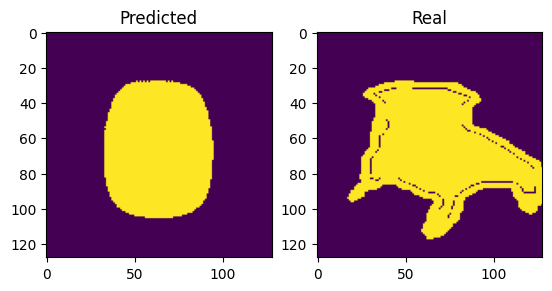

In [ ]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("./UNet.pth", map_location="cpu"))
data, label = test_set[1]
pred = model(torch.unsqueeze(data.to(device), dim=0)) > 0.5  # 픽셀을 이진 분류함
# 0.5 초과 여부로 이미지의 픽셀을 이진분류함

with torch.no_grad():  # 메모리 효율을 위해 gradient 기록 방지
   plt.subplot(1, 2, 1)
   plt.title("Predicted")
   plt.imshow(pred.cpu().squeeze())
   plt.subplot(1, 2, 2)
   plt.title("Real")
   plt.imshow(label)
   plt.show()